In [221]:
import random
import matplotlib.pyplot as plt
import numpy as np

We create *k* actions with unit expected rewards. These expected rewards are used to create normal
 random distributions with unit variance. When an action is selected we return a reward based on the distribution for that action. 

In [222]:
k = 10
expected_rewards = np.random.normal(0, 1, size=k)

print(expected_rewards)

def action(a):
    return random.normalvariate(expected_rewards[a], 1)

[-0.13305619 -0.12987378 -0.68534874 -1.37336164  1.24591224 -0.22161088
  0.40599407 -0.25980709  0.91141644  0.74755601]


We'll now create the functionality to update value estimates. We use a sample average method where we simply average all of the rewards obtained from the selected action so far.

In [223]:
estimates = [0] * k
times_selected = [0] * k

def sample_average_estimate(a, r):
    estimates[a] = (estimates[a] * times_selected[a] + r) / (times_selected[a] + 1)
    times_selected[a] += 1

Let's try a simple greedy action selection method. 

In [224]:
def greedy_select():
    # Select the indicies of all the apparent optimal actions
    max_actions = [action for action, value in enumerate(estimates) if value == max(estimates)]
    # Return a random choice from them
    return random.choice(max_actions)

In [225]:
for t in range(1000):
    a = greedy_select()
    r = action(a)
    sample_average_estimate(a, r)

print(estimates)

[0, -0.7443311679224531, 0, -0.950200951716955, 0, 0, 0, 0, 0, 0.7761742673591675]


We can see that several estimates are not updating because we are not exploring at all. 

To fix this, let's try a slightly more sophisticated action selection method which randomly selects actions with some probability.

In [226]:
def epsilon_greedy_select(epsilon):
    if random.random() < epsilon:
        return random.choice(range(k))
    return greedy_select()

estimates = [0] * k
times_selected = [0] * k

for t in range(1000):
    a = epsilon_greedy_select(0.10)
    r = action(a)
    sample_average_estimate(a, r)

print(estimates)

[0.04898914740129847, -0.5659606247999855, -0.2711695371717004, -0.7883156375397197, 1.216635166276591, 0.05322589569730966, 0.24470461240602753, -0.3745851527181535, 0.8768871192698743, 0.886224677833631]


To compare the two methods, we can create a testbed. Here, we compare the greedy method with two epsilon methods with epsilon-values of 0.01 and 0.1. We run each method 2000 times to 1000 timesteps. Each run, we create a new set of actions.

In [227]:
runs = 10000

rewards_greedy = []
rewards_e_greedy = []
rewards_e_greedy2 = []

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(1000):
        a = greedy_select()
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_greedy.append(row)

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(1000):
        a = epsilon_greedy_select(0.01)
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_e_greedy.append(row)

for run in range(runs):
    row = []
    expected_rewards = [random.normalvariate(0, 1) for _ in range(k)]
    estimates = [0] * k
    times_selected = [0] * k
    for t in range(1000):
        a = epsilon_greedy_select(0.1)
        r = action(a)
        sample_average_estimate(a, r)
        row.append(r)
    rewards_e_greedy2.append(row)

rewards_greedy_average = np.mean(rewards_greedy, axis=0)
rewards_e_greedy_average = np.mean(rewards_e_greedy, axis=0)
rewards_e_greedy2_average = np.mean(rewards_e_greedy2, axis=0)

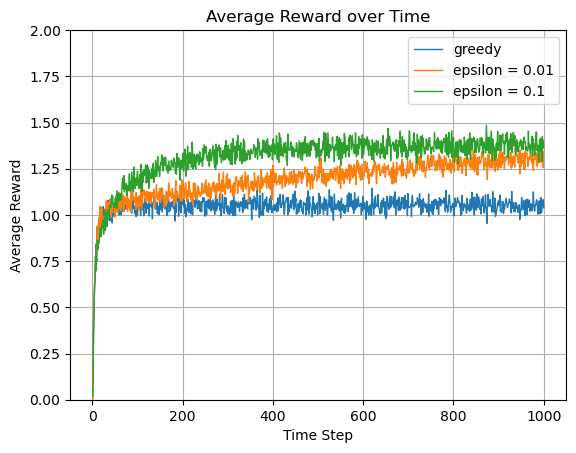

In [ ]:
plt.plot(range(1, len(rewards_greedy_average) + 1), rewards_greedy_average, label="greedy", linewidth=1)
plt.plot(range(1, len(rewards_e_greedy_average) + 1), rewards_e_greedy_average, label="epsilon = 0.01", linewidth=1)
plt.plot(range(1, len(rewards_e_greedy2_average) + 1), rewards_e_greedy2_average, label="epsilon = 0.1", linewidth=1)
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 2)
plt.show()